In [1]:
import pyomo.environ as pe
import pandas as pd
import numpy as np

## Data

In [2]:
# Transportation costs
trans_costs = {
    ('S1','DC1'): 0.003,
    ('S1','DC2'): 0.003,
    ('S2','DC1'): 0.003,
    ('S2','DC2'): 0.003,
    ('DC1','DC2'):0.003,
    ('DC1','RET1'):0.002,
    ('DC1','CUS1'):0.287,
    ('DC1','CUS2'):0.288,
    ('DC2','DC1'):0.065,
    ('DC2','RET1'):0.043,
    ('DC2','RET2'):0.052,
    ('DC2','CUS1'):0.287,
    ('DC2','CUS2'):0.302,
    ('RET1','RET2'):0.101,
    ('RET1','CUS1'):0.284,
    ('RET1','CUS2'):0.299,
    ('RET1','CUS3'):0.0001,
    ('RET2','RET1'):0.025,
    ('RET2','CUS1'):0.287,
    ('RET2','CUS2'):0.287,
    ('RET2','CUS4'):0.0001
    }

In [3]:
supply = ['S1','S2']

In [4]:
# Warehouse
wh = {
    'DC1':{'HC':0.0165,'InitInv':2000,'MaxInv':3000,'L':7},
    'DC2':{'HC':0.1,'InitInv':2000,'MaxInv':3000,'L':7}
}

In [5]:
# Retail
rt = {
    'RET1':{'HC':0.1,'InitInv':500,'MaxInv':800,'L':3},
    'RET2':{'HC':0.1,'InitInv':500,'MaxInv':800,'L':3}
}

In [6]:
# Customers
cus = {
   'CUS1':{'dd':245.06,'sigma2':3.455,'ST':1},
   'CUS2':{'dd':82.5,'sigma2':2.627,'ST':1},
   'CUS3':{'dd':56.53,'sigma2':6.814,'ST':0},
   'CUS4':{'dd':36.32,'sigma2':3.349,'ST':0}
}

In [7]:
# timeframe
time = list(range(0,13))

## Model

### Base model (without police)

In [8]:
model = pe.ConcreteModel()

In [9]:
# Sets
model.time = pe.Set(initialize = time)
model.wh = pe.Set(initialize = wh.keys())
model.rt = pe.Set(initialize = rt.keys())
model.cus = pe.Set(initialize = cus.keys())
model.supply = pe.Set(initialize = supply)
# Tuples
model.trans = pe.Set(initialize = trans_costs.keys())

In [10]:
# Decision variables
model.x = pe.Var(model.trans,model.time,domain = pe.NonNegativeReals)
model.inv = pe.Var(model.wh.union(model.rt),model.time,domain = pe.NonNegativeReals)

In [11]:
# Constraints
def demand_constraint(model,c,time):
    if time>0:
        return sum(model.x[i,c,time] for i in model.rt.union(model.wh) if (i,c) in model.trans) == cus[c]['dd']
    else:
        return sum(model.x[i,c,time] for i in model.rt.union(model.wh) if (i,c) in model.trans) == 0.
model.demand_constraint = pe.Constraint(model.cus,model.time,rule = demand_constraint)

In [12]:
def inv_wh(model,j,time):
    if time > 0:
        return model.inv[j,time] == model.inv[j,time-1] + sum(model.x[ss,j,time] for ss in model.supply if (ss,j) in model.trans)\
             - sum(model.x[j,rt,time] for rt in model.rt if (j,rt) in model.trans) - sum(model.x[j,c,time] for c in model.cus if (j,c) in model.trans)
    else:
        return pe.Constraint.Skip
model.inv_wh = pe.Constraint(model.wh,model.time,rule = inv_wh)

In [13]:
def inv_wh_ini_end(model,j,time):
    if time == 0 or time == 12:
        return model.inv[j,time] == wh[j]['InitInv']
    else:
        return pe.Constraint.Skip
model.inv_wh_ini_end = pe.Constraint(model.wh,model.time,rule = inv_wh_ini_end)

In [14]:
def inv_rt(model,k,time):
    if time > 0:
        return model.inv[k,time] == model.inv[k,time-1] + sum(model.x[wh,k,time] for wh in model.wh if (wh,k) in model.trans)\
            - sum(model.x[k,c,time] for c in model.cus if (k,c) in model.trans)
    else:
        return model.inv[k,time] == rt[k]['InitInv']
model.inv_rt = pe.Constraint(model.rt,model.time,rule = inv_rt)

In [15]:
def inv_rt_ini_end(model,k,time):
    if time == 0 or time == 12:
        return model.inv[k,time] == rt[k]['InitInv']
    else:
        return pe.Constraint.Skip
model.inv_rt_ini_end = pe.Constraint(model.rt,model.time,rule = inv_rt_ini_end)

In [16]:
def max_inv_wh(model,i,time):
    return model.inv[i,time] <= wh[i]['MaxInv']
model.max_inv_wh = pe.Constraint(model.wh,model.time,rule = max_inv_wh)


In [17]:
def max_inv_rt(model,i,time):
    return model.inv[i,time] <= rt[i]['MaxInv']
model.max_inv_rt = pe.Constraint(model.rt,model.time,rule = max_inv_rt)

In [18]:
def objective(model):
   # revenue_rt = sum(10 * model.x[k,c,time] for k in model.rt for c in model.cus for time in model.time if (k,c) in model.trans if time > 0)
   # revenue_wh = sum(10 * model.x[j,c,time] for j in model.wh for c in model.cus for time in model.time if (j,c) in model.trans if time > 0)
    tc_ss_wh = sum(trans_costs[i,j] * model.x[i,j,time] for i in model.supply for j in model.wh for time in model.time if (i,j) in model.trans)
    tc_wh_rt = sum(trans_costs[j,k] * model.x[j,k,time] for j in model.wh for k in model.rt for time in model.time if (j,k) in model.trans )
    tc_rt_cus = sum(trans_costs[k,c] * model.x[k,c,time] for k in model.rt for c in model.cus for time in model.time if (k,c) in model.trans )
    tc_wh_cus = sum(trans_costs[j,c] * model.x[j,c,time] for j in model.wh for c in model.cus for time in model.time if (j,c) in model.trans )
    hc_wh = sum(wh[j]['HC'] * model.inv[j,time] for j in model.wh for time in model.time ) 
    hc_rt = sum(rt[k]['HC'] * model.inv[k,time] for k in model.rt for time in model.time )
    return  (tc_ss_wh + tc_wh_rt + tc_rt_cus + tc_wh_cus + hc_wh + hc_rt) #revenue_rt + revenue_wh
model.objective = pe.Objective(rule = objective, sense = pe.minimize)

In [19]:
optimizer = pe.SolverFactory('cbc')

In [20]:
results = optimizer.solve(model,options = {"threads":4},tee = True)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - /home/victormoura/anaconda3/envs/iff_opt/bin/cbc -threads 4 -printingOptions all -import /tmp/tmpzx5cz4fq.pyomo.lp -stat=1 -solve -solu /tmp/tmpzx5cz4fq.pyomo.soln (default strategy 1)
threads was changed from 0 to 4
Option for printingOptions changed from normal to all
Presolve 72 (-91) rows, 200 (-74) columns and 376 (-153) elements
Statistics for presolved model


Problem has 72 rows, 200 columns (200 with objective) and 376 elements
There are 24 singletons with objective 
Column breakdown:
156 of type 0.0->inf, 44 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
20 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
52 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Ran

/tmp/ipykernel_3286/3949031875.py:11: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = df.pivot(index = 'time', columns='inv',values='value')


<AxesSubplot: xlabel='time'>

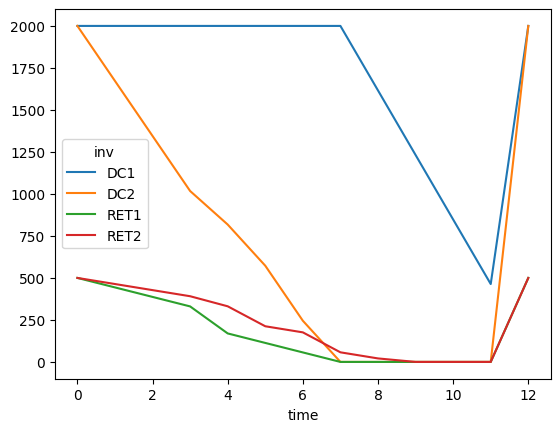

In [34]:
inventory = model.inv.extract_values()
col = ['time','inv','value']
df = pd.DataFrame(columns=col)
for ivalues in inventory.keys():
    df = pd.concat([df,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues[1],
                                col[1]:ivalues[0],
                                col[2]:inventory[ivalues]
                            }])],ignore_index=True)
df = df.pivot(index = 'time', columns='inv',values='value')
df.plot()

In [37]:
flow = model.x.extract_values()
col_ = ['time','from','To','value']
df_flow = pd.DataFrame(columns=col_)
for ivalues in flow.keys():
    df_flow = pd.concat([df_flow,
                    pd.DataFrame.from_records([{
                                col_[0]:ivalues[2],
                                col_[1]:ivalues[0],
                                col_[2]:ivalues[1],
                                col_[3]:flow[ivalues]
                            }])],ignore_index=True)
#df = df.pivot(index = 'time', columns='from',values='value')
#df.plot()

In [38]:
df_flow

,time,from,To,value
0,0,S1,DC1,0.00
1,1,S1,DC1,0.00
2,2,S1,DC1,0.00
3,3,S1,DC1,0.00
4,4,S1,DC1,0.00
...,...,...,...,...
268,8,RET2,CUS4,36.32
269,9,RET2,CUS4,36.32
270,10,RET2,CUS4,36.32
271,11,RET2,CUS4,36.32
